In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
from collections import OrderedDict
import h5py

import pickle as pkl

#Charon
import sys
# sys.path.append("/data/user/niovine/software/charon/charon")
from charon import propa
import charon.physicsconstants as PC
pc = PC.PhysicsConstants()
from IntRate import *

# <font color="darkmagenta">Charon flux at production, including EW corrections</font>
Fluxes are given as $\frac{dN}{dE}$ with units $GeV^{-1}$
The spectra are given for:
- EW and noEW: dd, uu, ss, cc, bb, tt, gg, WW, ZZ, HH, ee, mumu, tautau, 
- EW only: nuenue, numunumu, nutaunutau
- Masses: $m_{\chi}$ in GeV ranging from 5 GeV to 1000 TeV
- Locations: Earth, Sun, Halo (+specify zenith)
- Processes: ann or decay

# <font color=darkmagenta>Extract spectra at source</font>

In [23]:
#Informations about dark matter
channels = ["WW","bb","tautau","mumu","nuenue","numunumu","nutaunutau"]
masses = [6, 10, 30, 50, 70, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000]

flavours = ["nu_mu","nu_e", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
process = "ann" 

#Mass of the final state particles
p_mass = {'bb':4.18,'WW':80.379,'tautau':1.776,'mumu':105e-3, "nunu":0., "nuenue":0., "numunumu":0., "nutaunutau":0.}



##Oscillation parameters##
#from https://arxiv.org/pdf/1811.05487.pdf
theta_12 = 33.82
theta_13 = 8.61
theta_23 = 49.7
delta_m_12 = 7.39e-5
delta_m_13 = 2.525e-3
delta = 217.

print ("Oscillation parameters: theta12={}, theta13={}, theta23={}, m12={}, m13={}, delta={}".format(str(theta_12), str(theta_13), str(theta_23), str(delta_m_12), str(delta_m_13), str(delta)))


#Info of neutrino spectrum binning 
nodes = 100
bins = 300

#Linear binning 
logscale = False #default
#Include interactions
interactions = True #default

Oscillation parameters: theta12=33.82, theta13=8.61, theta23=49.7, m12=7.39e-05, m13=0.002525, delta=217.0


In [5]:
#Define zenith of the Galactic Centre
GC_zen = np.deg2rad(-29.00781+90)
print ("Galactic Centre location:", GC_zen)

flux_at_Source = dict()
flux_at_Earth = dict()

Emin=1.


for channel in channels:
    flux_at_Source[channel] = dict()
    flux_at_Earth[channel] = dict()
    
    for mass in masses :
        
        if process == "ann" and mass < p_mass[channel]: 
            continue
        elif process == "decay" and mass < 2*p_mass[channel]: 
            continue
        
        print ("----------------------")
        print ("### {} {} GeV ###".format(channel,str(mass)))
        print ("----------------------")

        flux_at_Source[channel][str(mass)] = dict()
        flux_at_Earth[channel][str(mass)] = dict()
        
        Emin         = 1.
        Emax         = mass
    
        #Object construction
        Flux = propa.NuFlux(channel, mass, nodes, Emin=Emin, Emax=Emax, bins=bins,
                            process=process, logscale=logscale, interactions=interactions,
                            theta_12=theta_12, theta_13=theta_13, theta_23=theta_23,
                            delta_m_12=delta_m_12, delta_m_13=delta_m_13,delta=delta)
        
        E = Flux.iniE()
        print ("Before:", min(E), max(E))
        
        for flavour in flavours:
            
            flux_at_Source[channel][str(mass)][flavour] = dict()
            flux_at_Earth[channel][str(mass)][flavour] = dict()
            
            ##Flux at source##
            flux_ini_Halo  = Flux.iniFlux('Halo')
            flux_at_Source[channel][str(mass)][flavour]["E"] = E
            flux_at_Source[channel][str(mass)][flavour]["dNdE"] = flux_ini_Halo[flavour]/float(mass) # Charon give flux as dN/dx with x= E/m
            
            print ("## Initial dNdE:", min(flux_at_Source[channel][str(mass)][flavour]["dNdE"]),max(flux_at_Source[channel][str(mass)][flavour]["dNdE"]))
            print ("## Inital E:", min(flux_at_Source[channel][str(mass)][flavour]["E"]), max(flux_at_Source[channel][str(mass)][flavour]["E"]))
            

            #Get the configuration for the right channel and mass
            t0 = time.time()
            flux_det_Halo_GC = Flux.Halo('detector', zenith=GC_zen)

            flux_at_Earth[channel][str(mass)][flavour]["E"] = flux_det_Halo_GC["Energy"]
            flux_at_Earth[channel][str(mass)][flavour]["dNdE"] = flux_det_Halo_GC[flavour]/float(mass)
            print ('averaged propagation, time duration:')
            print (time.time()-t0, 's')
                
            print ("## Oscillated dNdE:", min(flux_at_Earth[channel][str(mass)][flavour]["dNdE"]),max(flux_at_Earth[channel][str(mass)][flavour]["dNdE"]))
            print ("## Oscillated E:", min(flux_at_Earth[channel][str(mass)][flavour]["E"]), max(flux_at_Earth[channel][str(mass)][flavour]["E"]))
            
            
            
##Inital spectra##
# initial_file = "./Spectra_{}_Charon_atSource.pkl".format(process)
# print (initial_file)
# pkl.dump(flux_at_Source,open(initial_file,"wb"))

# ##Oscillated spectra##
# oscillated_file = "./Spectra_{}_Charon_atEarth.pkl".format(process) 
# print (oscillated_file)
# pkl.dump(flux_at_Earth,open(oscillated_file,"wb"))

Galactic Centre location: 1.0645145335019603
----------------------
### WW 90 GeV ###
----------------------
Before: 1.0 90.0
Initial Flux Loading: /home/nhan/anaconda3/lib/python3.8/site-packages/charon-0.1.0-py3.8.egg/charon/data/Spectra_PYTHIA.hdf5
## Initial dNdE: 0.0 4.608601325047755
## Inital E: 1.0 90.0
Initial Flux Loading: /home/nhan/anaconda3/lib/python3.8/site-packages/charon-0.1.0-py3.8.egg/charon/data/Spectra_PYTHIA.hdf5
averaged propagation, time duration:
0.43754005432128906 s
## Oscillated dNdE: 0.0 2.4754024540576216
## Oscillated E: 1.0 90.0
Initial Flux Loading: /home/nhan/anaconda3/lib/python3.8/site-packages/charon-0.1.0-py3.8.egg/charon/data/Spectra_PYTHIA.hdf5
## Initial dNdE: 0.0 2.2603068157383155
## Inital E: 1.0 90.0
Initial Flux Loading: /home/nhan/anaconda3/lib/python3.8/site-packages/charon-0.1.0-py3.8.egg/charon/data/Spectra_PYTHIA.hdf5
averaged propagation, time duration:
0.3959047794342041 s
## Oscillated dNdE: 0.0 2.043861054292205
## Oscillated E: 1.

# <font color=darkmagenta>Plot the Charon spectra</font>

In [5]:
# channels and masses show in the plots:
channels = ["WW", "bb", "mumu", "tautau", "nuenue","numunumu","nutaunutau"]
# channels = ["numunumu"]
mass = [100, 1000]
nu_type =  'nu_mu' #'nu_e' #'nu_tau' #nu_e_bar' #'nu_mu_bar' #'nu_tau_bar' #'nu_tau' #'nu_mu' #

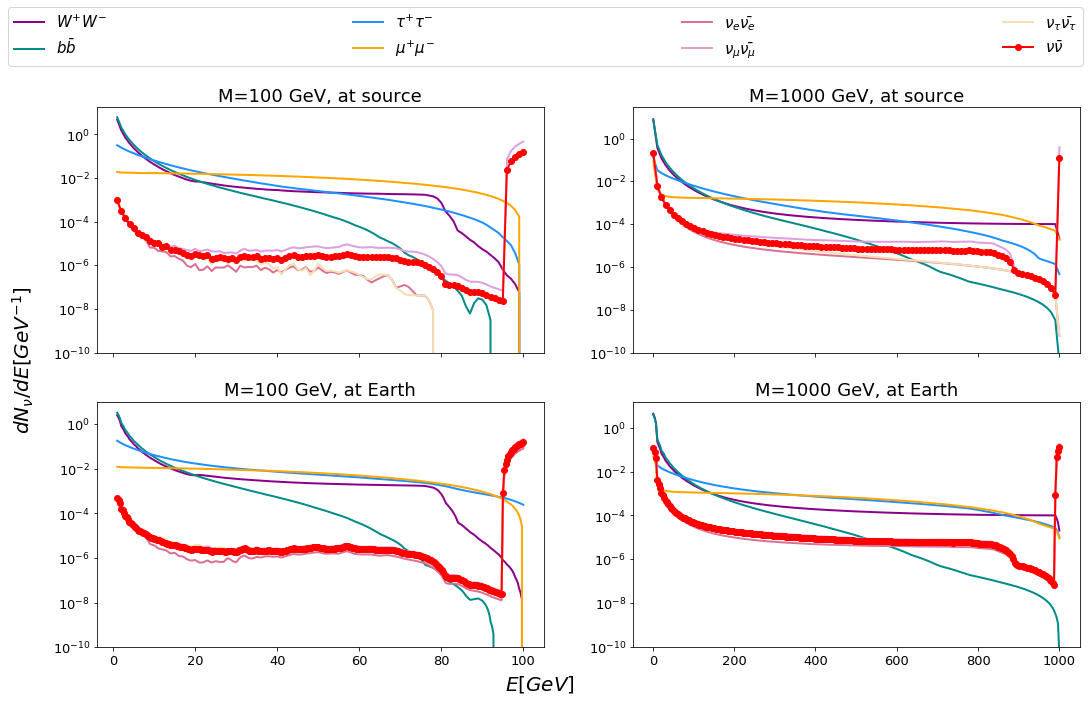

In [24]:
colors = {"WW":"darkmagenta","tautau":"dodgerblue","mumu":"orange","bb":"darkcyan","nuenue":"palevioletred","numunumu":"plum","nutaunutau":"wheat", "nunu":"red"}
legends = {"WW":r"$W^{+}W^{-}$","tautau":r"$\tau^{+}\tau^{-}$","mumu":r"$\mu^{+}\mu^{-}$","bb":r"$b\bar{b}$","nuenue":r"$\nu_e\bar{\nu_e}$","numunumu":r"$\nu_\mu\bar{\nu_\mu}$","nutaunutau":r"$\nu_\tau\bar{\nu_\tau}$"}
labels_nutype = {'nu_e':r"$\nu_{e}$",'nu_mu':r"$\nu_{\mu}$",'nu_tau':r"$\nu_{\tau}$",'nu_e_bar':r"$\bar{\nu}_{e}$",'nu_mu_bar':r"$\bar{\nu}_{\mu}$",'nu_tau_bar':r"$\bar{\nu}_{\tau}$"}


flux_Earth_ann = pkl.load(open("Spectra_ann_Charon_atEarth.pkl","rb"))
flux_Earth_decay = pkl.load(open("Spectra_decay_Charon_atEarth.pkl","rb"))

flux_Source_ann = pkl.load(open("Spectra_ann_Charon_atSource.pkl","rb"))
flux_Source_decay = pkl.load(open("Spectra_decay_Charon_atSource.pkl","rb"))

flux_ann = [flux_Source_ann, flux_Earth_ann]

# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    
plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(2, 2, sharex='col')

# Spectra:
for i in range(0, len(mass)): # 2 mass: 100 (left), 1000 (right)
    for j in range(0, len(flux_ann)): # at Source (upper), at Earth (lower)
        for channel in channels:
            E = flux_ann[j][channel][str(mass[i])][nu_type]["E"]
            flux = flux_ann[j][channel][str(mass[i])][nu_type]["dNdE"]
            axs[j,i].plot(E,flux,linewidth=2.0,label=legends[channel],color=colors[channel])
        # Make nunubar flux as average of three nunubar channel:
        flux_nunubar = (flux_ann[j]["nuenue"][str(mass[i])][nu_type]["dNdE"] + flux_ann[j]["numunumu"][str(mass[i])][nu_type]["dNdE"] + flux_ann[j]["nutaunutau"][str(mass[i])][nu_type]["dNdE"])/3.
        axs[j,i].plot(E,flux_nunubar,linewidth=2.0,label=r"$\nu \bar{\nu}$",color="red", marker = 'o')
#         axs[j,i].xlim(0,masses[i]+10)
        axs[j,i].semilogy()
#         axs[j,i].semilogx()
        axs[j,i].set_ylim(1e-10)
        axs[j,i].set_title("M={} GeV, at {}".format(str(mass[i]), "source" if (j==0) else "Earth" ), fontsize=18)

# fig.xlabel(r"$E [GeV]$")
# fig.ylabel(r"$dN_\nu/dE [GeV^{-1}]$")
fig.text(0.5, 0.04, r"$E [GeV]$", ha='center', fontsize=20)
fig.text(0.01, 0.5, r"$dN_\nu/dE [GeV^{-1}]$", va='center', rotation='vertical', fontsize=20)
# fig.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=5)

lines, labels = fig.axes[-1].get_legend_handles_labels()   
fig.legend(lines, labels, loc = "upper center", ncol=4, mode='expand', fontsize=15)
# fig.tight_layout()
plt.subplots_adjust(left=0.09,
                    bottom=0.1, 
                    right=1., 
                    top=0.85, 
                    wspace=0.2, 
                    hspace=0.2)
plt.show()


# <font color=darkmagenta>Charon spectra: nuSquid vs averaged oscillation</font>

Doing channel: WW
Doing channel: bb
Doing channel: tautau
Doing channel: mumu
Doing channel: nuenue
Doing channel: numunumu
Doing channel: nutaunutau


Text(0.05,0.5,'$dN_\\nu/dE [GeV^{-1}]$')

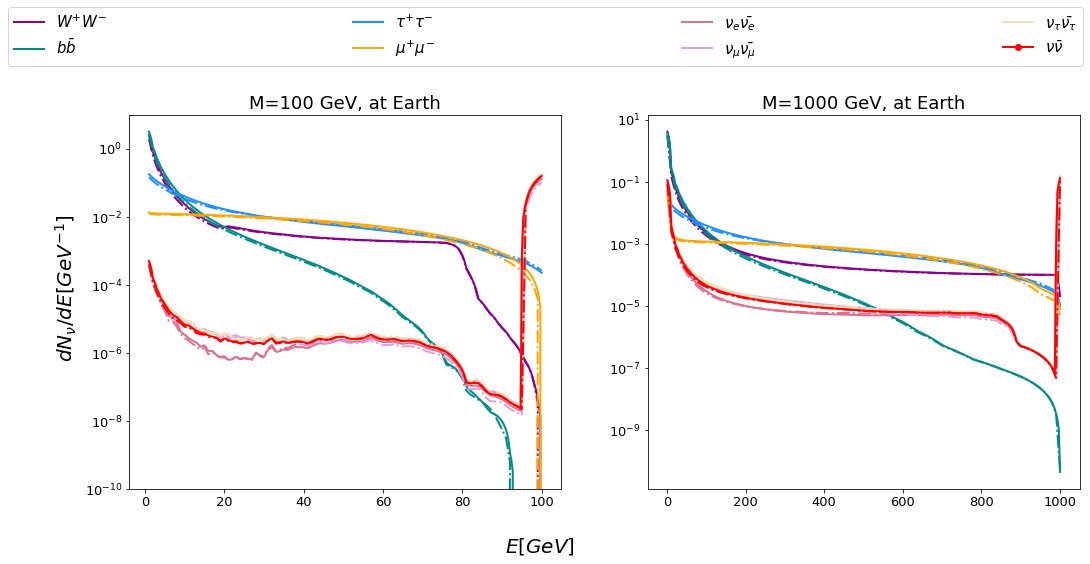

In [25]:
# Averaged oscillation:
oscillated_charon = dict()
nu_types = ["nu_mu","nu_e", "nu_tau"]
for channel in channels:
        print ("Doing channel:", channel)
        
        oscillated_charon[channel] = dict()

        for m in mass:
            
            oscillated_charon[channel][str(m)] = dict()

            #Oscillate neutrinos
            osc_nu = oscillate_spectra(flux_Source_ann[channel][str(m)], ["nu_mu","nu_e", "nu_tau"])
            
            #Spectra after oscillation
            for nu_type in nu_types:
                oscillated_charon[channel][str(m)][nu_type] = dict()
                oscillated_charon[channel][str(m)][nu_type]["E"] = flux_Source_ann[channel][str(m)][nu_type]["E"]
                oscillated_charon[channel][str(m)][nu_type]["dNdE"] = osc_nu["dNdE_"+nu_type+"_osc"]
                
# print(len(flux_Source_ann["WW"][str("1000")]["nu_mu"]["E"]))


# Compared nusquid vs averaged oscillation:
plt.rcParams['figure.figsize'] = [15, 8]
fig, axs = plt.subplots(1, 2, sharex='col')

# Spectra:
for i in range(0, len(mass)): # 2 mass: 100 (left), 1000 (right)
        for channel in channels:
            E = flux_Earth_ann[channel][str(mass[i])][nu_type]["E"]
            flux = flux_Earth_ann[channel][str(mass[i])][nu_type]["dNdE"]
            flux_avgosc = np.asarray(oscillated_charon[channel][str(mass[i])][nu_type]["dNdE"])
            axs[i].plot(E,flux,linewidth=2.0,label=legends[channel],color=colors[channel])
            E_source = flux_Source_ann[channel][str(mass[i])][nu_type]["E"] # E bins at Earth and source is different
            axs[i].plot(E_source,flux_avgosc,linewidth=2.0,label=legends[channel],color=colors[channel], linestyle="-.")

        # Make nunubar flux as average of three nunubar channel:
        flux_nunu = (flux_Earth_ann["nuenue"][str(mass[i])][nu_type]["dNdE"] + 
                    flux_Earth_ann["numunumu"][str(mass[i])][nu_type]["dNdE"] + 
                    flux_Earth_ann["nutaunutau"][str(mass[i])][nu_type]["dNdE"])/3.
        flux_nunu_avgosc = (np.asarray(oscillated_charon["nuenue"][str(mass[i])][nu_type]["dNdE"]) + 
                            np.asarray(oscillated_charon["numunumu"][str(mass[i])][nu_type]["dNdE"]) + 
                            np.asarray(oscillated_charon["nutaunutau"][str(mass[i])][nu_type]["dNdE"]))/3.
        
        axs[i].plot(E,flux_nunu,linewidth=2.0,label=r"$\nu \bar{\nu}$",color="red")
        axs[i].plot(E_source,flux_nunu_avgosc,linewidth=2.0,label=r"$\nu \bar{\nu}$",color="red", linestyle="-.")

#         axs[j,i].xlim(0,masses[i]+10)
        axs[i].semilogy()
#         axs[j,i].semilogx()
#         axs[j,i].set_ylim(1e-10)
        axs[i].set_title("M={} GeV, at {}".format(str(mass[i]), "source" if (j==0) else "Earth" ), fontsize=18)
    
# lines, labels = fig.axes[-1].get_legend_handles_labels()  
plt.subplots_adjust(left=0.12,
                    bottom=0.15, 
                    right=1., 
                    top=0.8, 
                    wspace=0.2, 
                    hspace=0.2)
fig.legend(lines, labels, loc = "upper center", ncol=4, mode='expand', fontsize=15)    
fig.text(0.5, 0.04, r"$E [GeV]$", ha='center', fontsize=20)
fig.text(0.05, 0.5, r"$dN_\nu/dE [GeV^{-1}]$", va='center', rotation='vertical', fontsize=20)
                

# <font color=darkmagenta>Plot the PPPC4 spectra</font>

In [26]:
channels = ["WW", "bb", "mumu", "tautau", "nuenue","numunumu","nutaunutau"]
nu_types = ["nu_mu","nu_e", "nu_tau"]

PPPC4_tables = extract_PPPC4tables(channels, masses)
PPPC4_oscillated = oscillate_PPPC4(channels, masses,nu_types)

Doing channel: WW
Doing channel: bb
Doing channel: mumu
Doing channel: tautau
Doing channel: nuenue
Doing channel: numunumu
Doing channel: nutaunutau


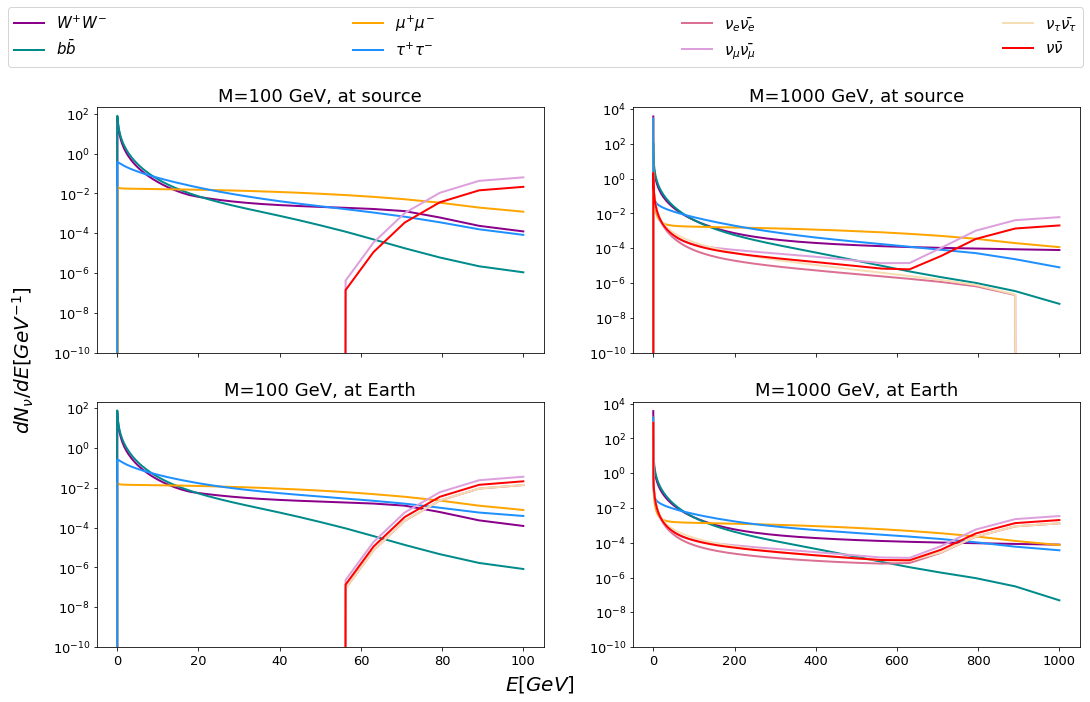

In [27]:
# Plot PPPC4 spectra
# Spectra:
PPPC4_flux=[PPPC4_tables, PPPC4_oscillated]
plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(2, 2, sharex='col')
nu_type="nu_mu"
for i in range(0, len(mass)): # 2 mass: 100 (left), 1000 (right)
    for j in range(0, len(PPPC4_flux)): # at Source (upper), at Earth (lower)
        for channel in channels:
            E = PPPC4_flux[j][channel][str(mass[i])][nu_type]["E"]
            flux = PPPC4_flux[j][channel][str(mass[i])][nu_type]["dNdE"]
            axs[j,i].plot(E,flux,linewidth=2.0,label=legends[channel],color=colors[channel])
        # Make nunubar flux as average of three nunubar channel:
        flux_nunubar = (np.asarray(PPPC4_flux[j]["nuenue"][str(mass[i])][nu_type]["dNdE"]) + 
                        np.asarray(PPPC4_flux[j]["numunumu"][str(mass[i])][nu_type]["dNdE"]) + 
                        np.asarray(PPPC4_flux[j]["nutaunutau"][str(mass[i])][nu_type]["dNdE"]))/3.
        axs[j,i].plot(E,flux_nunubar,linewidth=2.0,label=r"$\nu \bar{\nu}$",color="red")
        axs[j,i].semilogy()
#         axs[j,i].semilogx()
        axs[j,i].set_ylim(1e-10)
        axs[j,i].set_title("M={} GeV, at {}".format(str(mass[i]), "source" if (j==0) else "Earth" ), fontsize=18)

# fig.xlabel(r"$E [GeV]$")
# fig.ylabel(r"$dN_\nu/dE [GeV^{-1}]$")
fig.text(0.5, 0.04, r"$E [GeV]$", ha='center', fontsize=20)
fig.text(0.01, 0.5, r"$dN_\nu/dE [GeV^{-1}]$", va='center', rotation='vertical', fontsize=20)
# fig.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=5)

lines, labels = fig.axes[-1].get_legend_handles_labels()   
fig.legend(lines, labels, loc = "upper center", ncol=4, mode='expand', fontsize=15)
# fig.tight_layout()
plt.subplots_adjust(left=0.09,
                    bottom=0.1, 
                    right=1., 
                    top=0.85, 
                    wspace=0.2, 
                    hspace=0.2)
plt.show()


# <font color=darkmagenta>Charon vs PPPC4 spectra</font>

Text(0.05,0.5,'$dN_\\nu/dE [GeV^{-1}]$')

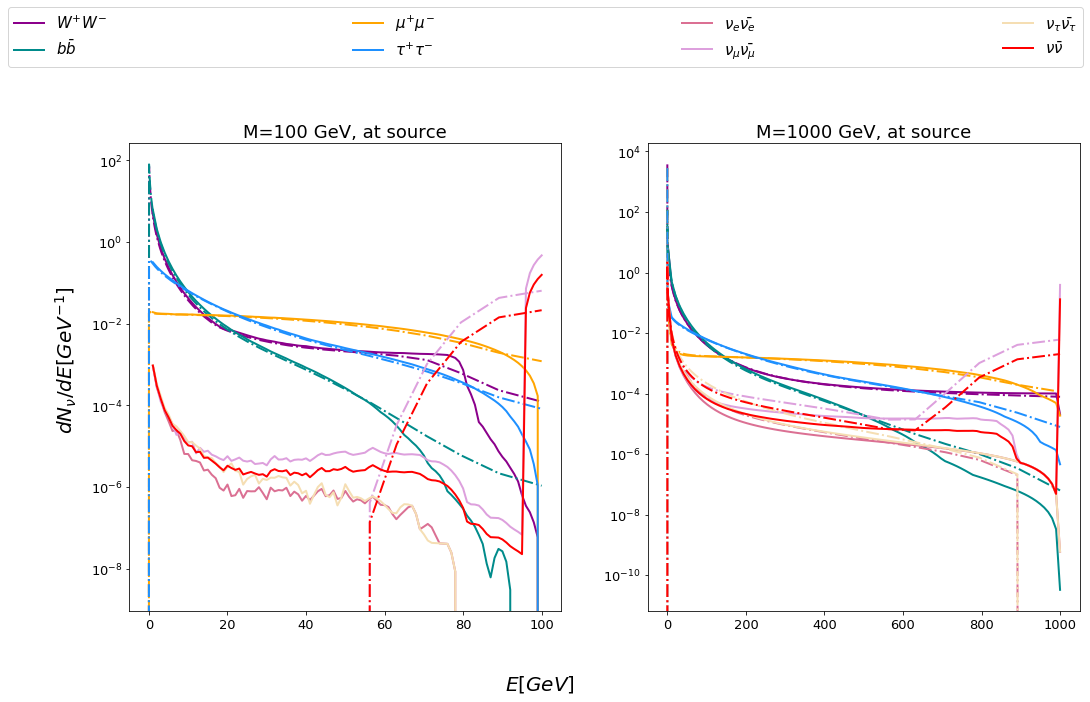

In [28]:
# Compared Charon vs PPPC4:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(1, 2, sharex='col')

# Spectra:
for i in range(0, len(mass)): # 2 mass: 100 (left), 1000 (right)
        for channel in channels:
            E = flux_Source_ann[channel][str(mass[i])][nu_type]["E"]
            flux_charon = flux_Source_ann[channel][str(mass[i])][nu_type]["dNdE"]
            flux_PPPC4 = np.asarray(PPPC4_tables[channel][str(mass[i])][nu_type]["dNdE"])
            axs[i].plot(E,flux_charon,linewidth=2.0,label=legends[channel],color=colors[channel])
            E_PPPC4 = PPPC4_tables[channel][str(mass[i])][nu_type]["E"] # E bins for 2 flux might be different
            axs[i].plot(E_PPPC4,flux_PPPC4,linewidth=2.0,label=legends[channel],color=colors[channel], linestyle="-.")

        # Make nunubar flux as average of three nunubar channel:
        flux_nunu = (flux_Source_ann["nuenue"][str(mass[i])][nu_type]["dNdE"] + 
                    flux_Source_ann["numunumu"][str(mass[i])][nu_type]["dNdE"] + 
                    flux_Source_ann["nutaunutau"][str(mass[i])][nu_type]["dNdE"])/3.
        flux_nunu_PPPC4 = (np.asarray(PPPC4_tables["nuenue"][str(mass[i])][nu_type]["dNdE"]) + 
                            np.asarray(PPPC4_tables["numunumu"][str(mass[i])][nu_type]["dNdE"]) + 
                            np.asarray(PPPC4_tables["nutaunutau"][str(mass[i])][nu_type]["dNdE"]))/3.
        
        axs[i].plot(E,flux_nunu,linewidth=2.0,label=r"$\nu \bar{\nu}$",color="red")
        axs[i].plot(E_PPPC4,flux_nunu_PPPC4,linewidth=2.0,label=r"$\nu \bar{\nu}$",color="red", linestyle="-.")

#         axs[j,i].xlim(0,masses[i]+10)
        axs[i].semilogy()
#         axs[j,i].semilogx()
#         axs[i].set_ylim(1e-20)
        axs[i].set_title("M={} GeV, at source".format(str(mass[i])), fontsize=18)

# lines, labels = fig.axes[-1].get_legend_handles_labels()  
plt.subplots_adjust(left=0.12,
                    bottom=0.15, 
                    right=1., 
                    top=0.8, 
                    wspace=0.2, 
                    hspace=0.2)
fig.legend(lines, labels, loc = "upper center", ncol=4, mode='expand', fontsize=15)    
fig.text(0.5, 0.04, r"$E [GeV]$", ha='center', fontsize=20)
fig.text(0.05, 0.5, r"$dN_\nu/dE [GeV^{-1}]$", va='center', rotation='vertical', fontsize=20)

IndexError: list index out of range

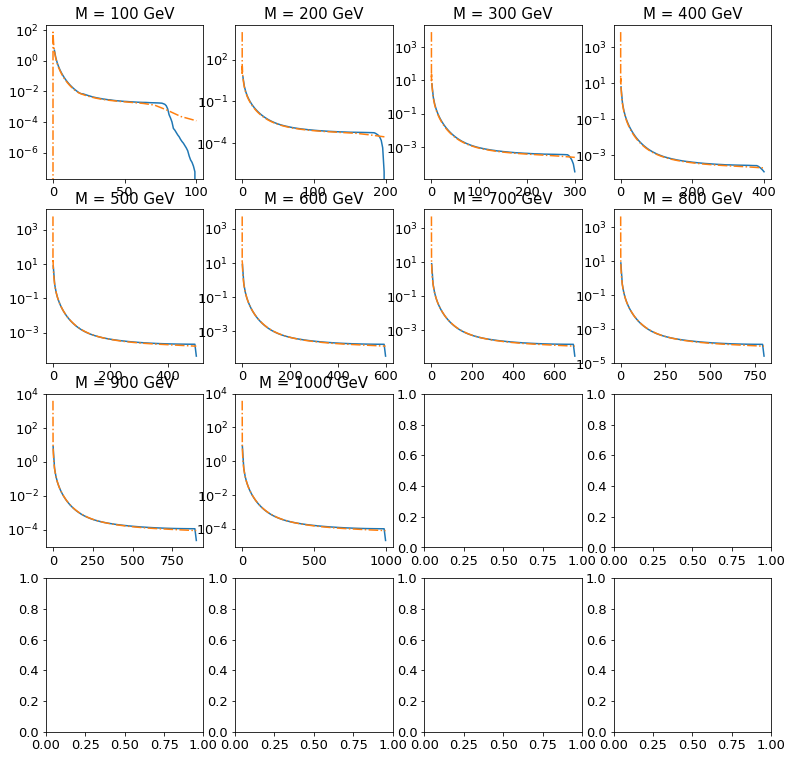

In [32]:
masses = [6, 10, 30, 50, 70, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
masses = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

plt.rcParams.update({'font.size': 13})
plt.rcParams['figure.figsize'] = [13, 13]
channel='WW'
nuflux='nu_mu'
fig, axs = plt.subplots(4,4)
im = 0

for ix in range(0, 4):
    for iy in range(0, 4):
        axs[ix, iy].plot(flux_Source_ann[channel][str(masses[im])]["nu_tau"]["E"], flux_Source_ann[channel][str(masses[im])]['nu_mu']["dNdE"], label='charon')
        axs[ix, iy].plot(PPPC4_tables[channel][str(masses[im])]["nu_tau"]["E"], PPPC4_tables[channel][str(masses[im])]['nu_mu']["dNdE"], linestyle='-.', label='PPPC4')

        axs[ix, iy].set_title("M = {} GeV".format(masses[im]), fontsize=15)
        axs[ix, iy].semilogy()
        im+=1
plt.subplots_adjust(left=0.12,
                    bottom=0.05, 
                    right=1., 
                    top=0.8, 
                    wspace=0.25, 
                    hspace=0.3)
fig.text(0.5, 0.01, r"$E [GeV]$", ha='center', fontsize=20)
fig.text(0.05, 0.5, r"$dN_\nu/dE [GeV^{-1}]$", va='center', rotation='vertical', fontsize=20)
# lines, labels = fig.axes[-1].get_legend_handles_labels()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
# chan_str = legends[channel]
# nu_str = labels[nuflux]
fig.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(0.08, 0.89), title=r"{} - {} flux".format(legends[channel],labels_nutype[nuflux]), ncol=2)

# fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
print(flux_Source_ann['bb']['30']['nu_mu']["dNdE"])
print(flux_Source_ann['bb']['30']['nu_mu']["E"])
